<a href="https://colab.research.google.com/github/Leiming-Ding/AIMaster-CSCA5622Fake-News-Detection---Machine-Learning-Project/blob/main/DeepLearningWeek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing with Disaster Tweets

## Description of the problem and data
### Nowadays, people often use social media to get or share information. The purpose of this project is to use natural language processing skills to detect tweets about a real disaster. It is a challenging problem because people can discuss any topics online. Traditional methods, such as engineering features from the tweet texts, may not work very well because it is hard to develop features. Deep learning methods, including recurrent neural networks, long short-term memory, and gated recurrent unit, may better capture the sequence of the information, which may better help detect the information

## Data information
### The training dataset contains five variables: id, keyword, location, text and target. There is missing information in the variables of keyword and location, so we just focus on id, text and target. Id is the Id information of the tweet. Text is the tweets. Target is whether the tweet is about a disastrous event (1 for yes and 0 for no). In the training dataset, there are 7613 observations, and in the test dataset, there are 3263 observations. I will use the training set to develop and validate the model and then use the test set to predict the information.

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


100%|██████████| 593k/593k [00:00<00:00, 107MB/s]

Extracting files...
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import pandas as pd


print(nlp_getting_started_path)

data_dir = nlp_getting_started_path

# List files in that folder
print(os.listdir(data_dir))

# Load datasets
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
sample_submission_df = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

# Take a quick look
print(train_df.shape)
train_df.head()


/root/.cache/kagglehub/competitions/nlp-getting-started
['train.csv', 'test.csv', 'sample_submission.csv']
(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df.info()
train_df.head()
train_df['target'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,count
target,
0,4342
1,3271


## Exploratory data analysis
### Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? I first showed the histogram of the outcome variable: 4342 tweets are not about a disastrous event but 3271 tweets are about a disastrous event. For the variable of "text", I engineered two new variables: length of the text and word count of the text, and also used histograms to visualize them. From the word count information, I know that most of the tweets are below 30. For the data cleaning process, I remove three variable: id, keyword and location. For the "text" variable, I tokenized them and added paddings to make each tweet the same length. My plan of analysis is to use deep learning models like RNN, LSTM, GRU and bi-LSTM because they are good at capturing the sequential information.

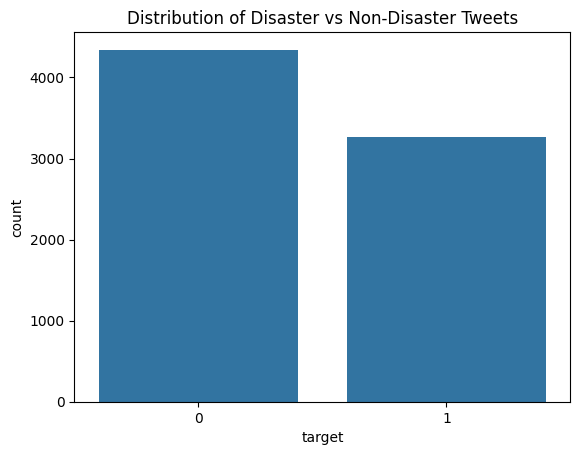

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=train_df, x='target')
plt.title("Distribution of Disaster vs Non-Disaster Tweets")
plt.show()

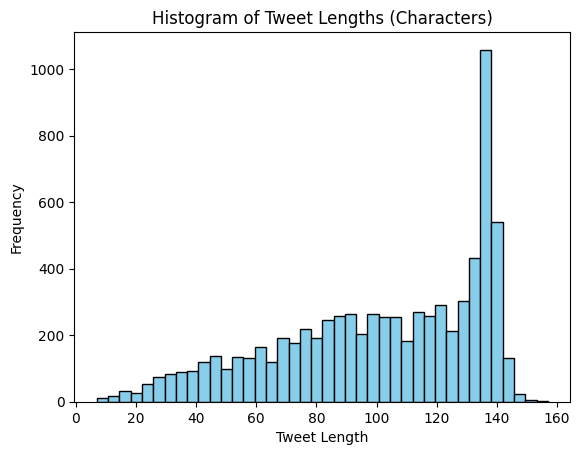

In [ ]:
train_df['text_len'] = train_df['text'].apply(len)
plt.hist(train_df['text_len'], bins=40, color='skyblue', edgecolor='black')
plt.title("Histogram of Tweet Lengths (Characters)")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

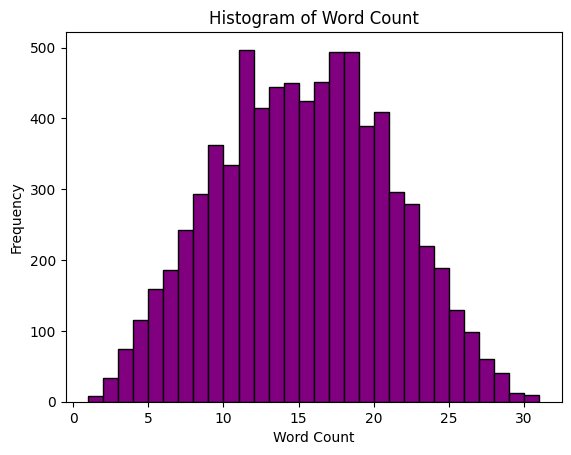

In [ ]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))

plt.hist(train_df['word_count'], bins=30, color='purple', edgecolor='black')
plt.title("Histogram of Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
!pip install tokenizers
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

# Build a tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="<unk>"))
tokenizer.pre_tokenizer = Whitespace()

trainer = WordLevelTrainer(special_tokens=["<pad>", "<unk>"])

tokenizer.train_from_iterator(train_df["text"].astype(str).tolist(), trainer)

vocab = tokenizer.get_vocab()
pad_id = vocab["<pad>"]

In [ ]:
MAX_LEN = 40

def encode_and_pad(text):
    ids = tokenizer.encode(text).ids
    ids = ids[:MAX_LEN]
    ids += [pad_id] * (MAX_LEN - len(ids))
    return ids

## Model architecture
### To convert the raw text into a numerical format suitable for a sequential neural network, I used a Word-Level tokenizer implemented with the tokenizers library. This tokenizer splits each sentence into words using simple whitespace rules, which ensures that each word is treated as an individual token. I trained a WordLevel vocabulary on the training texts, allowing the tokenizer to build a mapping from each unique word to an integer ID. Two special tokens were added: <pad> for sequence padding and <unk> for words not seen during training. After training, each piece of text is transformed into a list of token IDs that represent the words in the sentence. Because neural networks require inputs of uniform length, I applied padding: sequences longer than the maximum length are truncated, while shorter sequences are padded with the <pad> token’s ID. This ensures that all input sequences have the same length and can be batched efficiently during model training. This word-level tokenization and padding procedure provides a straightforward and interpretable numerical representation of text data that is compatible with RNN-based architectures such as LSTMs, GRUs, and Bidirectional RNNs.


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

X = train_df['text'].astype(str).values
y = train_df['target'].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

class TweetDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels  # None for test set

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = torch.tensor(encode_and_pad(self.texts[idx]), dtype=torch.long)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return ids, label
        else:
            return ids

train_dataset = TweetDataset(X_train, y_train)
val_dataset   = TweetDataset(X_val, y_val)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Device: cpu


In [ ]:
vocab = tokenizer.get_vocab()
vocab_size = len(vocab)
print("Vocab size:", vocab_size)

Vocab size: 26189


In [ ]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)          # (batch, seq, embed_dim)
        output, h_n = self.rnn(embedded)      # h_n: (1, batch, hidden_dim)
        h_last = h_n.squeeze(0)               # (batch, hidden_dim)
        logits = self.fc(h_last).squeeze(1)   # (batch,)
        return logits


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        h_last = h_n.squeeze(0)
        logits = self.fc(h_last).squeeze(1)
        return logits


class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        output, h_n = self.gru(embedded)
        h_last = h_n.squeeze(0)
        logits = self.fc(h_last).squeeze(1)
        return logits


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bi-direction

    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        # h_n shape: (num_directions=2, batch, hidden_dim)
        h_fwd = h_n[0]
        h_bwd = h_n[1]
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)  # (batch, 2*hidden_dim)
        logits = self.fc(h_cat).squeeze(1)
        return logits

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)                     # (batch,)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)

        # validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.inference_mode():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)

        print(
            f"Epoch {epoch}/{epochs} "
            f"| Train loss: {avg_train_loss:.4f} "
            f"| Val Acc: {acc:.4f} "
            f"| Val F1: {f1:.4f}"
        )

    return model

In [ ]:
def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_acc": [],
        "val_f1": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        history["train_loss"].append(avg_train_loss)

        # Validation
        model.eval()
        all_preds, all_labels = [], []

        with torch.inference_mode():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)

        history["val_acc"].append(acc)
        history["val_f1"].append(f1)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Acc: {acc:.4f} | "
            f"Val F1: {f1:.4f}"
        )

    return model, history

In [ ]:
EMBED_DIM = 100
HIDDEN_DIM = 128

rnn_model  = RNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id)
lstm_model = LSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id)
gru_model  = GRUClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id)
bilstm_model = BiLSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id)

In [ ]:
rnn_model, rnn_hist = train_model(rnn_model, train_loader, val_loader, epochs=5)
lstm_model, lstm_hist = train_model(lstm_model, train_loader, val_loader, epochs=5)
gru_model, gru_hist = train_model(gru_model, train_loader, val_loader, epochs=5)
bilstm_model, bilstm_hist = train_model(bilstm_model, train_loader, val_loader, epochs=5)

Epoch 1/5 | Train Loss: 0.6849 | Val Acc: 0.5712 | Val F1: 0.0061
Epoch 2/5 | Train Loss: 0.6813 | Val Acc: 0.5699 | Val F1: 0.0091
Epoch 3/5 | Train Loss: 0.6774 | Val Acc: 0.5666 | Val F1: 0.0704
Epoch 4/5 | Train Loss: 0.6658 | Val Acc: 0.5640 | Val F1: 0.0377
Epoch 5/5 | Train Loss: 0.6720 | Val Acc: 0.5384 | Val F1: 0.5808
Epoch 1/5 | Train Loss: 0.6836 | Val Acc: 0.5614 | Val F1: 0.0319
Epoch 2/5 | Train Loss: 0.6538 | Val Acc: 0.6395 | Val F1: 0.5328
Epoch 3/5 | Train Loss: 0.6344 | Val Acc: 0.6382 | Val F1: 0.6139
Epoch 4/5 | Train Loss: 0.6257 | Val Acc: 0.5712 | Val F1: 0.0031
Epoch 5/5 | Train Loss: 0.6406 | Val Acc: 0.6520 | Val F1: 0.5787
Epoch 1/5 | Train Loss: 0.6821 | Val Acc: 0.6225 | Val F1: 0.5965
Epoch 2/5 | Train Loss: 0.6312 | Val Acc: 0.6441 | Val F1: 0.6583
Epoch 3/5 | Train Loss: 0.5464 | Val Acc: 0.7229 | Val F1: 0.6191
Epoch 4/5 | Train Loss: 0.4329 | Val Acc: 0.7492 | Val F1: 0.6774
Epoch 5/5 | Train Loss: 0.3397 | Val Acc: 0.7663 | Val F1: 0.7003
Epoch 1/5 

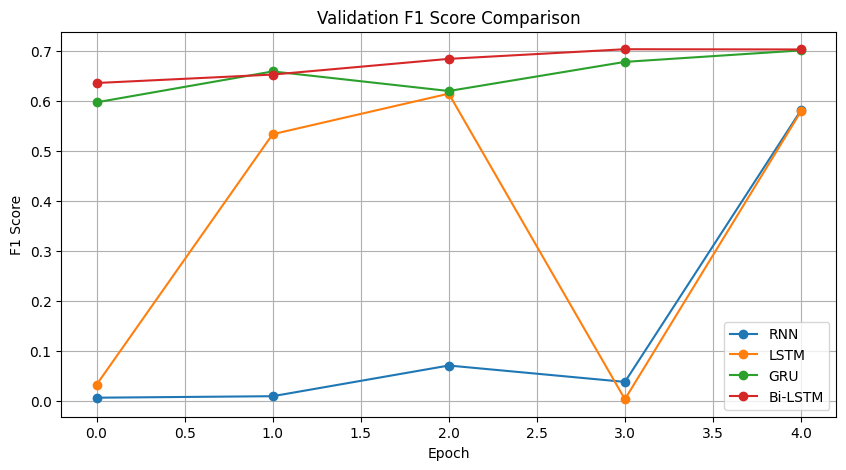

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rnn_hist["val_f1"], label="RNN", marker="o")
plt.plot(lstm_hist["val_f1"], label="LSTM", marker="o")
plt.plot(gru_hist["val_f1"], label="GRU", marker="o")
plt.plot(bilstm_hist["val_f1"], label="Bi-LSTM", marker="o")

plt.title("Validation F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

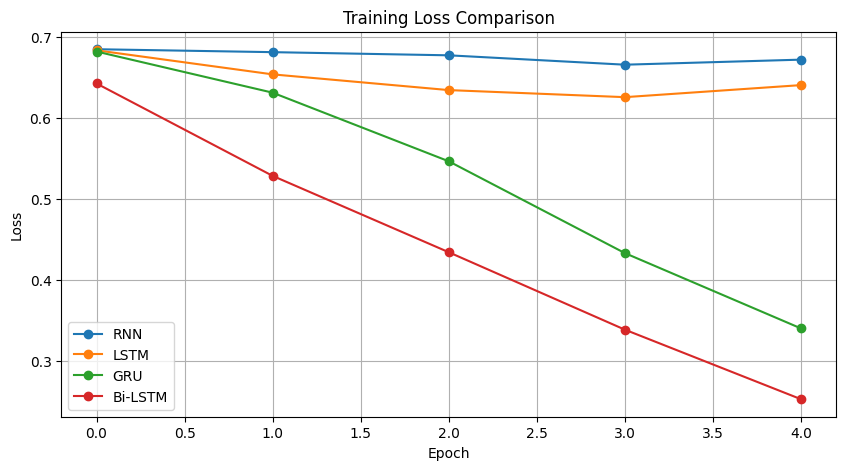

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rnn_hist["train_loss"], label="RNN", marker="o")
plt.plot(lstm_hist["train_loss"], label="LSTM", marker="o")
plt.plot(gru_hist["train_loss"], label="GRU", marker="o")
plt.plot(bilstm_hist["train_loss"], label="Bi-LSTM", marker="o")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
NUM_LAYERS = 2
DROPOUT = 0.3

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id,
                 num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.rnn = nn.RNN(
            embed_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            nonlinearity="tanh",
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        embedded = self.embedding(x)              # (batch, seq_len, embed_dim)
        output, h_n = self.rnn(embedded)          # h_n: (num_layers, batch, hidden_dim)
        h_last = h_n[-1]                          # last layer → (batch, hidden_dim)
        logits = self.classifier(h_last).squeeze(1)
        return logits


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id,
                 num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)  # h_n: (num_layers, batch, hidden_dim)
        h_last = h_n[-1]
        logits = self.classifier(h_last).squeeze(1)
        return logits


class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id,
                 num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.gru = nn.GRU(
            embed_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        embedded = self.embedding(x)
        output, h_n = self.gru(embedded)          # h_n: (num_layers, batch, hidden_dim)
        h_last = h_n[-1]
        logits = self.classifier(h_last).squeeze(1)
        return logits


class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_id,
                 num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        embedded = self.embedding(x)
        output, (h_n, c_n) = self.lstm(embedded)
        # h_n: (num_layers * 2, batch, hidden_dim)
        # last forward and backward states from the top layer:
        h_fwd = h_n[-2]   # (batch, hidden_dim)
        h_bwd = h_n[-1]   # (batch, hidden_dim)
        h_cat = torch.cat([h_fwd, h_bwd], dim=1)  # (batch, 2*hidden_dim)
        logits = self.classifier(h_cat).squeeze(1)
        return logits

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "val_acc": [],
        "val_f1": []
    }

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_train_loss = total_loss / len(train_loader.dataset)
        history["train_loss"].append(avg_train_loss)

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.inference_mode():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).long()

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        history["val_acc"].append(acc)
        history["val_f1"].append(f1)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Acc: {acc:.4f} | "
            f"Val F1: {f1:.4f}"
        )

    return model, history

In [ ]:
EPOCHS = 20
LR = 1e-3  # you can later try 5e-4 if it overfits

rnn_model   = RNNClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id,
                            num_layers=NUM_LAYERS, dropout=DROPOUT)
lstm_model  = LSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id,
                             num_layers=NUM_LAYERS, dropout=DROPOUT)
gru_model   = GRUClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id,
                            num_layers=NUM_LAYERS, dropout=DROPOUT)
bilstm_model = BiLSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, pad_id,
                                num_layers=NUM_LAYERS, dropout=DROPOUT)

rnn_model, rnn_hist       = train_model(rnn_model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
lstm_model, lstm_hist     = train_model(lstm_model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
gru_model, gru_hist       = train_model(gru_model, train_loader, val_loader, epochs=EPOCHS, lr=LR)
bilstm_model, bilstm_hist = train_model(bilstm_model, train_loader, val_loader, epochs=EPOCHS, lr=LR)

Epoch 1/20 | Train Loss: 0.6866 | Val Acc: 0.5706 | Val F1: 0.0030
Epoch 2/20 | Train Loss: 0.6841 | Val Acc: 0.6106 | Val F1: 0.5839
Epoch 3/20 | Train Loss: 0.6768 | Val Acc: 0.5515 | Val F1: 0.4726
Epoch 4/20 | Train Loss: 0.6856 | Val Acc: 0.5706 | Val F1: 0.0000
Epoch 5/20 | Train Loss: 0.6801 | Val Acc: 0.5680 | Val F1: 0.0090
Epoch 6/20 | Train Loss: 0.6815 | Val Acc: 0.5712 | Val F1: 0.0031
Epoch 7/20 | Train Loss: 0.6797 | Val Acc: 0.5706 | Val F1: 0.0030
Epoch 8/20 | Train Loss: 0.6786 | Val Acc: 0.5706 | Val F1: 0.0030
Epoch 9/20 | Train Loss: 0.6791 | Val Acc: 0.5712 | Val F1: 0.4599
Epoch 10/20 | Train Loss: 0.6783 | Val Acc: 0.5699 | Val F1: 0.4600
Epoch 11/20 | Train Loss: 0.6790 | Val Acc: 0.5693 | Val F1: 0.0030
Epoch 12/20 | Train Loss: 0.6786 | Val Acc: 0.5699 | Val F1: 0.0030
Epoch 13/20 | Train Loss: 0.6810 | Val Acc: 0.5706 | Val F1: 0.0000
Epoch 14/20 | Train Loss: 0.6784 | Val Acc: 0.5706 | Val F1: 0.0000
Epoch 15/20 | Train Loss: 0.6816 | Val Acc: 0.5706 | Val 

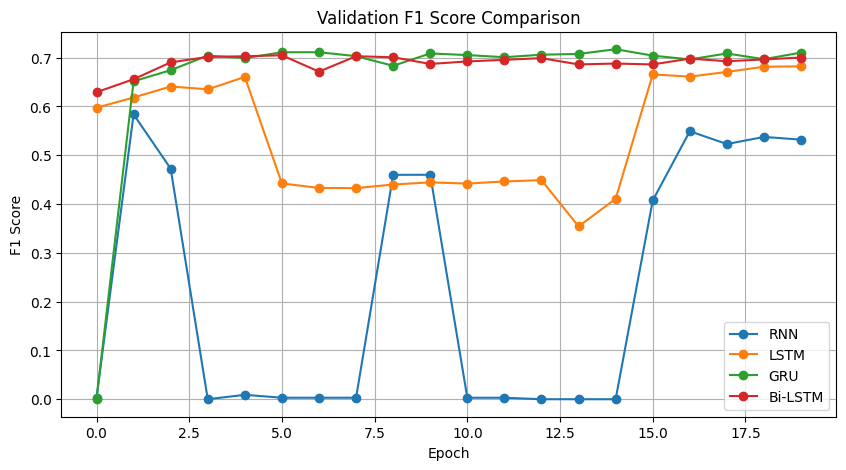

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rnn_hist["val_f1"], label="RNN", marker="o")
plt.plot(lstm_hist["val_f1"], label="LSTM", marker="o")
plt.plot(gru_hist["val_f1"], label="GRU", marker="o")
plt.plot(bilstm_hist["val_f1"], label="Bi-LSTM", marker="o")

plt.title("Validation F1 Score Comparison")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()

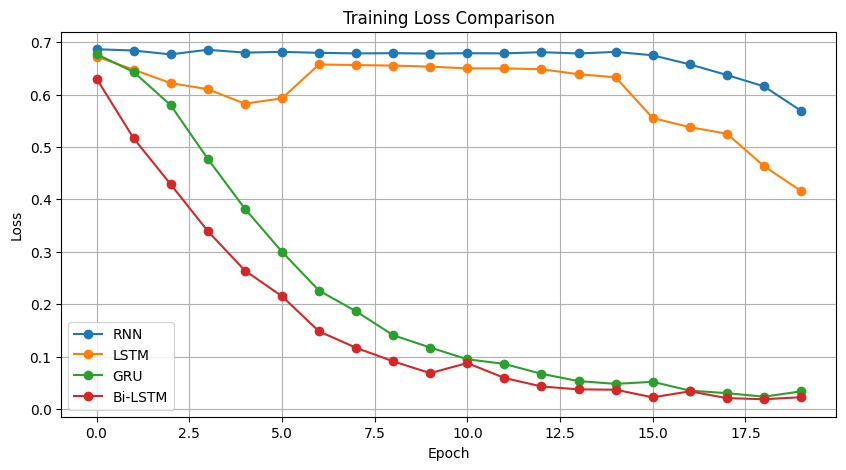

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(rnn_hist["train_loss"], label="RNN", marker="o")
plt.plot(lstm_hist["train_loss"], label="LSTM", marker="o")
plt.plot(gru_hist["train_loss"], label="GRU", marker="o")
plt.plot(bilstm_hist["train_loss"], label="Bi-LSTM", marker="o")

plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

## Results and analysis
### I estimated four deep learning models: RNN, LSTM, GRU, and bi-LSTM. First, I chose embedding dimension 100, hidden dimension 128, 5 epochs, 3 layers for each model, and no dropout.

### | Model       | Layers | Dropout | Bidirectional | Best Val_Accuracy | Best Val_F1 |
### | RNN         | 3      | No      | No            | 0.5712 | 0.0061 |
### | LSTM        | 3      | No      | No            | 0.6520 | 0.5787 |
### | GRU         | 3      | No      | No            | 0.7663 | 0.7003 |
### | BiLSTM      | 3      | No      | Yes           | 0.7577 | 0.7022 |


### I did the parameter tuning. I estimated the same four models but this time I added epoch to 20 to see whether there were steady results. I included 2 stacked layers and then had 5 layers in total. I also chose dropout of 0.3.

### | Model       | Layers | Dropout | Bidirectional | Best Val_Accuracy | Best Val_F1 |
### | RNN         | 5      | 0.3      | No            | 0.6238 | 0.5492 |
### | LSTM        | 5      | 0.3      | No            | 0.7137 | 0.6822 |
### | GRU         | 5      | 0.3      | No            | 0.7571 | 0.7087 |
### | BiLSTM      | 5      | 0.3      | Yes           | 0.7544 | 0.6904 |

### From these results, we can see that GRU and BiLSTM achieved better results than RNN and LSTM. Adding layers and dropout helped improve RNN and LSTM performance a bit, but did not change GRU and BiLSTM performance much. GRU and BiLSTM outperform RNN and LSTM because they are more effective at capturing sequential patterns and long-range dependencies with fewer parameters and better bidirectional context. Additional layers and dropout improved weaker models (RNN, LSTM) by increasing capacity and reducing overfitting, but did not noticeably improve GRU or BiLSTM because these architectures were already expressive enough for the task.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TweetDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels  # None for test set

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ids = torch.tensor(encode_and_pad(self.texts[idx]), dtype=torch.long)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return ids, label
        else:
            return ids

In [ ]:
test_texts = test_df["text"].astype(str).values

test_dataset = TweetDataset(test_texts, labels=None)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
bilstm_model.eval()
bilstm_model.to(device)

all_test_preds = []

with torch.inference_mode():
    for xb in test_loader:
        xb = xb.to(device)
        logits = bilstm_model(xb)           # (batch,)
        probs = torch.sigmoid(logits)       # (batch,)
        preds = (probs > 0.5).long()        # 0/1
        all_test_preds.extend(preds.cpu().numpy())

all_test_preds = np.array(all_test_preds)
print("Predictions shape:", all_test_preds.shape)

Predictions shape: (3263,)


In [ ]:
submission = pd.DataFrame({
    "id": test_df["id"],
    "target": all_test_preds
})

submission.head()
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

Saved submission.csv


In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion
### Learnings and takeaways: you need to understand the unique features of different sequential neural models and then choose the appropriate model. Just adding new features, such as stacked layers or dropout, would help with some model but not others. For example, GRU and BiLSTM achieved better results than RNN and LSTM. Adding layers and dropout helped improve RNN and LSTM performance a bit, but did not change GRU and BiLSTM performance much.

### I created the submission file and submitted to Kaggle. I got 0.73337. In the future, I would try some transformer-based moels, such as RoBERTa and DistilBERT to see their performance.
